In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system ==

Training classifier...
Epoch 01 Classifier Accuracy: 94.92%
Epoch 02 Classifier Accuracy: 97.35%
Epoch 03 Classifier Accuracy: 98.45%
Epoch 04 Classifier Accuracy: 99.20%
Epoch 05 Classifier Accuracy: 99.36%
Epoch 06 Classifier Accuracy: 99.62%
Epoch 07 Classifier Accuracy: 99.80%
Epoch 08 Classifier Accuracy: 99.92%
Epoch 09 Classifier Accuracy: 99.75%
Epoch 10 Classifier Accuracy: 99.92%
Epoch 11 Classifier Accuracy: 99.98%
Epoch 12 Classifier Accuracy: 100.00%
Epoch 13 Classifier Accuracy: 100.00%
Epoch 14 Classifier Accuracy: 100.00%
Epoch 15 Classifier Accuracy: 100.00%
Epoch 16 Classifier Accuracy: 100.00%
Epoch 17 Classifier Accuracy: 100.00%
Epoch 18 Classifier Accuracy: 100.00%
Epoch 19 Classifier Accuracy: 100.00%
Epoch 20 Classifier Accuracy: 100.00%
Epoch 21 Classifier Accuracy: 100.00%
Epoch 22 Classifier Accuracy: 100.00%
Epoch 23 Classifier Accuracy: 100.00%
Epoch 24 Classifier Accuracy: 100.00%
Epoch 25 Classifier Accuracy: 100.00%
Epoch 26 Classifier Accuracy: 100.00%


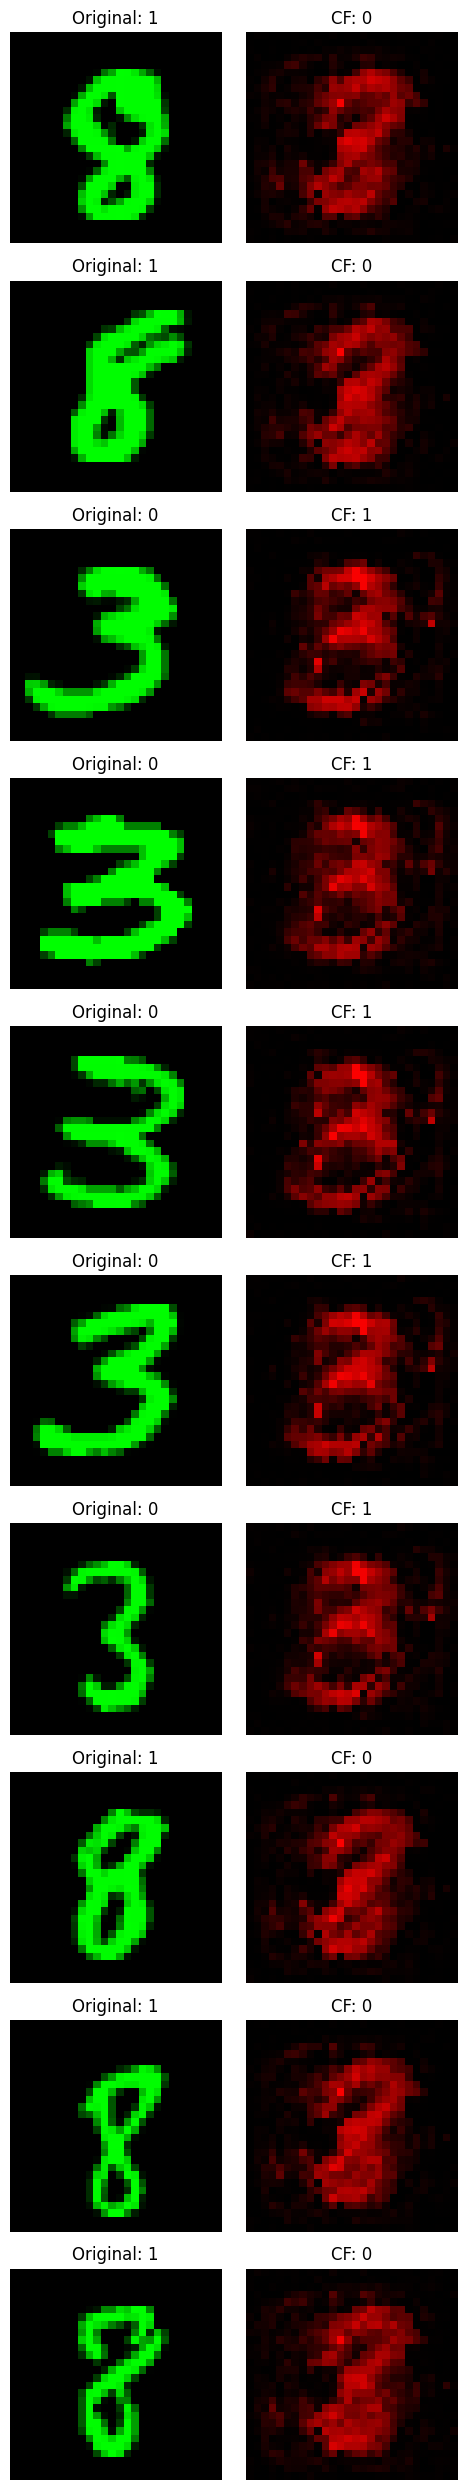

In [ ]:
"""
Extension of CFVAE for MNIST 8 vs 3 classification, passing the binary classifier as an argument.

Instead of tightly coupling the classifier within the model, this extension intends to pass the classifier to the CFVAE model as an argument to move toward generalization of the CFVAE model.
"""

import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from datasets import load_dataset

# Binary Classifier
class BinaryCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.model(x)

# CFVAE
class CFVAE(nn.Module):
    def __init__(self, feat_dim, emb_dim1, features, classifier):
        super(CFVAE, self).__init__()
        self.features = features
        self.classifier = classifier
        self.enc1 = nn.Sequential(
            nn.Linear(feat_dim, emb_dim1),
            nn.LayerNorm(emb_dim1),
            nn.ReLU()
        )
        self.enc2 = nn.Linear(emb_dim1, 2 * features)

        self.dec1 = nn.Sequential(
            nn.Linear(features + 2, emb_dim1),
            nn.LayerNorm(emb_dim1),
            nn.ReLU()
        )
        self.dec2 = nn.Linear(emb_dim1, feat_dim)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y):
        h = self.enc1(x)
        h = self.enc2(h).view(-1, 2, self.features)
        mu, logvar = h[:, 0, :], h[:, 1, :]
        z = self.reparameterize(mu, logvar)

        y_cf = 1 - y
        y_cf_onehot = F.one_hot(y_cf, num_classes=2).float()
        z_cond = torch.cat([z, y_cf_onehot], dim=1)

        h_dec = self.dec1(z_cond)
        x_recon = torch.sigmoid(self.dec2(h_dec))

        pred = self.classifier(x_recon)
        return x_recon, mu, logvar, pred

# Loss
def final_loss(bce, mu, logvar, kl_weight=1.0):
    kld = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
    return bce + kl_weight * kld

# Visualization
def visualize_cfvae_color_digits(model, X, Y, device, n=10):
    """
    Displays the original and counterfactual images side-by-side in color,
    highlighting digit strokes.
    """
    model.eval()
    x = torch.from_numpy(X).float().squeeze(-1).to(device)
    y_true = torch.from_numpy(Y).squeeze().to(device)

    with torch.no_grad():
        x_recon, _, _, pred_cf = model(x, y_true)
        logits_orig = model.classifier(x)
        logits_cf = pred_cf

    prob_orig = F.softmax(logits_orig, dim=1)
    prob_cf = F.softmax(logits_cf, dim=1)
    pred_orig = prob_orig.argmax(dim=1)
    pred_cf_class = prob_cf.argmax(dim=1)

    x_orig = x.view(-1, 28, 28).cpu()
    x_cf = x_recon.view(-1, 28, 28).cpu()

    # Choose top n most confidently flipped examples
    flip_mask = (pred_orig != pred_cf_class)
    conf_diff = (prob_cf - prob_orig).abs().max(dim=1)[0]
    sorted_idx = torch.argsort(conf_diff, descending=True)
    flipped_idx = sorted_idx[flip_mask[sorted_idx]][:n]

    if len(flipped_idx) == 0:
        print("No counterfactual flips found.")
        return

    fig, axs = plt.subplots(len(flipped_idx), 2, figsize=(5, 2.5 * len(flipped_idx)))
    axs = axs if len(flipped_idx) > 1 else [axs]

    for i, idx in enumerate(flipped_idx):
        orig = x_orig[idx].numpy()
        cf = x_cf[idx].numpy()

        # Highlight strokes in green for original and red for CF
        orig_rgb = np.zeros((28, 28, 3))
        cf_rgb = np.zeros((28, 28, 3))
        orig_rgb[:, :, 1] = orig  # green channel for original
        cf_rgb[:, :, 0] = cf      # red channel for CF

        axs[i][0].imshow(orig_rgb)
        axs[i][0].set_title(f"Original: {pred_orig[idx].item()}")
        axs[i][1].imshow(cf_rgb)
        axs[i][1].set_title(f"CF: {pred_cf_class[idx].item()}")

        axs[i][0].axis('off')
        axs[i][1].axis('off')

    plt.tight_layout()
    plt.show()


def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ds = load_dataset("ylecun/mnist")
    images = np.stack(ds["train"]["image"])
    labels = np.array(ds["train"]["label"])

    mask = np.isin(labels, [3, 8])
    images, labels = images[mask], labels[mask]
    labels = np.where(labels == 3, 0, 1)

    X = (images / 255.0).astype(np.float32).reshape(-1, 784, 1)
    Y = labels.reshape(-1, 1)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

    tensor_dataset = TensorDataset(torch.tensor(X_train).view(-1, 1, 28, 28), torch.tensor(Y_train.squeeze(), dtype=torch.long))
    clf_loader = DataLoader(tensor_dataset, batch_size=64, shuffle=True)

    classifier = BinaryCNN().to(device)
    clf_opt = optim.Adam(classifier.parameters(), lr=1e-3)
    clf_criterion = nn.CrossEntropyLoss()

    print("Training classifier...")
    for epoch in range(30):
        correct, total = 0, 0
        for x, y in clf_loader:
            x, y = x.to(device), y.to(device)
            clf_opt.zero_grad()
            out = classifier(x.view(-1, 28 * 28))
            loss = clf_criterion(out, y)
            loss.backward()
            clf_opt.step()
            pred = out.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
        acc = 100.0 * correct / total
        print(f"Epoch {epoch+1:02d} Classifier Accuracy: {acc:.2f}%")

    classifier.eval()
    for p in classifier.parameters():
        p.requires_grad = False

    model = CFVAE(784, 128, 128, classifier).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss(reduction='mean')
    criterion_cf = nn.CrossEntropyLoss()
    bs = 64

    print("Training CFVAE...")
    for epoch in range(1, 101):
        kl_weight = min(1.0, epoch / 10.0)
        cf_weight = min(100.0, 5.0 * epoch)  # for faster ramp-up
        sparsity_weight = 0.01
        loss_wt = [1.0, cf_weight, sparsity_weight]

        model.train()
        for i in range(0, X_train.shape[0], bs):
            x = torch.from_numpy(X_train[i:i+bs]).float().to(device).squeeze(-1)
            y = torch.from_numpy(Y_train[i:i+bs]).long().to(device).squeeze()
            y_cf = 1 - y
            x_recon, mu, logvar, pred = model(x, y)
            bce = criterion(x_recon, x)
            vae_loss = final_loss(bce, mu, logvar, kl_weight)
            cf_loss = criterion_cf(pred, y_cf) # counterfactual loss
            sparse_loss = F.l1_loss(x_recon, x, reduction='mean') # sparsity loss
            loss = loss_wt[0] * vae_loss + loss_wt[1] * cf_loss + loss_wt[2] * sparse_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluation
        model.eval()
        all_targets, all_preds, all_probs, _ = [], [], [], []
        num_flipped = 0
        with torch.no_grad():
            for i in range(0, X_test.shape[0], bs):
                x = torch.from_numpy(X_test[i:i+bs]).float().to(device).squeeze(-1)
                y = torch.from_numpy(Y_test[i:i+bs]).long().to(device).squeeze()
                y_cf = 1 - y
                x_recon, mu, logvar, pred = model(x, y)

                prob = F.softmax(pred, dim=1)[:, 1]
                predicted = prob.round().long()
                all_targets.extend(y_cf.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())
                all_probs.extend(prob.cpu().numpy())

                orig_logits = classifier(x)
                orig_pred = orig_logits.argmax(dim=1)
                cf_pred = pred.argmax(dim=1)
                num_flipped += (orig_pred != cf_pred).sum().item()

        acc = accuracy_score(all_targets, all_preds)
        auc = roc_auc_score(all_targets, all_probs)
        conf = confusion_matrix(all_targets, all_preds)
        flip_rate = num_flipped / len(Y_test)

        print(f"Epoch {epoch:03d} | Val Loss: {loss:.2f} | AUC: {auc:.4f} | Acc: {acc:.4f} | Flip Rate: {flip_rate:.2%}")
        print(f"  Confusion Matrix:\n{conf}\n")

    visualize_cfvae_color_digits(model, X_test, Y_test, device, n=10)

if __name__ == '__main__':
    main()
